In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.special import digamma
from sklearn.gaussian_process import GaussianProcessRegressor
import gpytorch

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

/Users/menang/anaconda3/envs/py3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


A simple simulation experimental setup:
$$f(x)=x\log x,\;x\in[0,1],\;X|Y=y \sim \textrm{Beta}(\alpha(y),\beta(y)).$$
$f$ has a minimum at $x=1/e$ (no local minima). We can compute
$$g(y)=\mathbb E_{X|Y=y}\left[X\log X\right]=\frac{\alpha(y)}{\alpha(y)+\beta(y)}\left[\psi(\alpha(y)+1)-\psi(\alpha(y)+\beta(y)+1)\right],$$
where $\psi$ is the digamma function. To complete the setup need to choose some functions $\alpha:\mathcal Y\to (0,+\infty)$, $\beta:\mathcal Y\to (0,+\infty),$ e.g. take $\mathcal Y=\mathbb R^3$ and
$$\alpha(y)=\exp(a^\top y+c),\;\beta(y)=\exp(b^\top y+d),$$
or similar.

Nb. the bounded domain of $X$ might need to be built into the kernel construction when estimating CME $X|Y$, e.g. one can use
$$k(x,x')=\exp\left(-\frac{1}{2\gamma^2}\left(\log\frac{x}{1-x}-\log\frac{x'}{1-x'}\right)^2\right),\quad x,x'\in(0,1).$$


In [2]:
def alpha(y,a=1,c=0):
    return np.exp(a * y +c)

def beta(y, b=1, d=0):
    return np.exp(b* y + d)

def func(x):
    return x * np.log(x)

def g(y,a=1,b=0,c=1,d=0):
    alpha_value = alpha(y,a,c)
    beta_value = beta(y,b,d)
    g_value = alpha_value/(alpha_value+beta_value) * (digamma(alpha_value + 1) - digamma(alpha_value + beta_value + 1))
    return g_value

In [3]:
def generate_D1(n, a,b,c,d):
    ys = np.random.uniform(0,1,n)
    alphas = []
    betas = []
    xs = []
    fs = []
    for i in ys:
        alpha_value = alpha(i,a,c)
        alphas.append(alpha_value)
        
        beta_value = beta(i,b,d)
        betas.append(beta_value)
        x_value = np.random.beta(alpha_value, beta_value)
        xs.append(x_value)
    plt.plot(ys, xs, '.')
    plt.xlabel('y')
    plt.ylabel('x')
    plt.title('D1')
    
    plt.legend()
    return np.asarray(xs), np.asarray(ys)
    

def generate_D2(m, a,b,c,d, sigma=0.01, plot=True):
    ys = np.random.uniform(0,1,m)
    zs = []
    
    alphas = []
    betas = []
    xs = []
    fs = []
    for y in ys:
        alpha_value = alpha(y,a,c)
        alphas.append(alpha_value)
        
        beta_value = beta(y,b,d)
        betas.append(beta_value)
        x_value = np.random.beta(alpha_value, beta_value)
        xs.append(x_value)
        fs.append(func(x_value))  
        
        g_value = g(y, a,b,c,d)
        z_value = g_value + np.random.normal(0, sigma)
        zs.append(z_value)
        
    if plot:    
        # plt.plot(ys, xs, '.', label = 'x')
        # plt.plot(fs, xs, '.', label = 'f(x)')
        
        plt.plot(ys, zs,'.')
        plt.xlabel('y')
        plt.ylabel('z (aggregated feedback)')
        plt.title('D2')
        
    return np.asarray(ys), np.asarray(zs)

In [4]:
a = 0.1
b = 4
c = 2
d = 0
sigma = 0.01

In [5]:
# a = 1
# b = 4
# c = 0
# d = 1

No handles with labels found to put in legend.


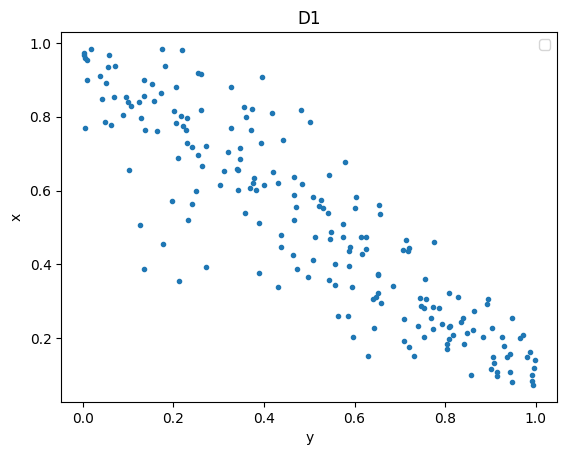

In [6]:
xs, ys = generate_D1(200,a,b,c,d)

Text(0, 0.5, 'f(x)')

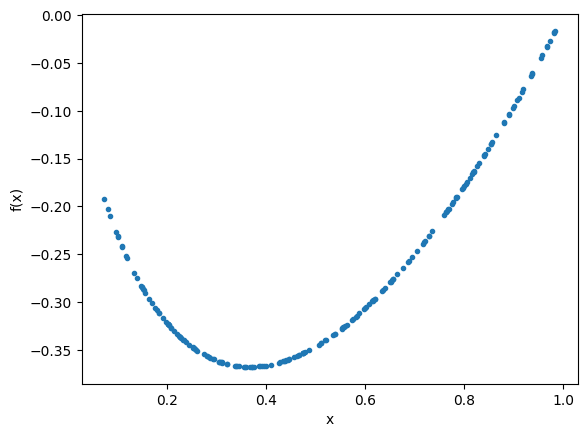

In [7]:
plt.plot(xs, func(xs), '.')
plt.xlabel('x')
plt.ylabel('f(x)')

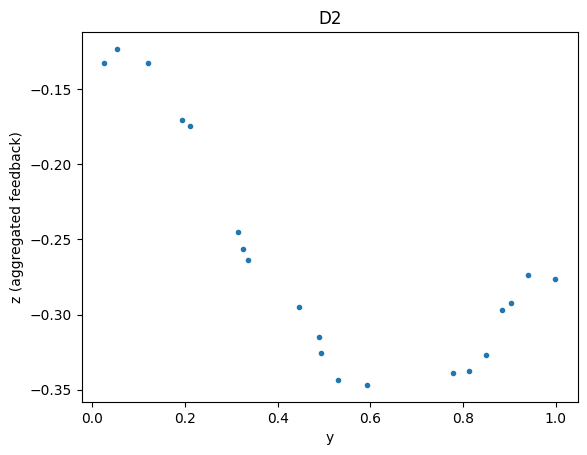

In [8]:
ys2, zs = generate_D2(20, a,b,c,d, sigma)

In [9]:
# ys2 = agent_random.y_recs
# zs = agent_random.z_rewards

# plt.plot(ys2, zs,'.')
# plt.xlabel('y')
# plt.ylabel('z (aggregated feedback)')
# plt.title('D2')

In [10]:
ys2

array([0.84960646, 0.33704695, 0.88327073, 0.02617758, 0.11979603,
       0.48970816, 0.81169963, 0.49256433, 0.21088227, 0.19439047,
       0.44620513, 0.77882617, 0.94015748, 0.32552688, 0.90281321,
       0.99837174, 0.05440194, 0.52956283, 0.59353904, 0.31556456])

In [11]:
muz, sigmaz = zs.mean(), zs.std()
zs = (zs - muz) / sigmaz

In [12]:
import sys
# sys.path.append("../deconditional-downscaling/")
sys.path.append("experiments/swiss_roll/")
from models import build_model, train_model, predict 
import yaml 
import torch

cdf_dir = 'experiments/swiss_roll/config/exact_cmp_mz.yaml' 
# cdf_dir = 'exact_cmp.yaml' 

with open(cdf_dir, "r") as f:
    cfg = yaml.safe_load(f)

cfg['model'].update(individuals=torch.tensor(xs).float(),
                    extended_bags_values=torch.tensor(ys).float(),
                    bags_values=torch.tensor(ys2).float(),
                    aggregate_targets=torch.tensor(zs).float(),
                    bags_sizes=len(ys))
model = build_model(cfg['model'])

In [13]:
groundtruth_individuals = torch.tensor(np.linspace(1e-5,1-1e-5,100)).float()

cfg['training'].update(model=model,
                    individuals=torch.tensor(xs).float(),
                    extended_bags_values=torch.tensor(ys).float(),
                    bags_values=torch.tensor(ys2).float(),
                    aggregate_targets=torch.tensor(zs).float(),
                    bags_sizes=len(ys),
                    groundtruth_individuals=groundtruth_individuals,
                    groundtruth_bags_sizes=len(groundtruth_individuals),
                    groundtruth_targets=func(groundtruth_individuals).float(),
                    chunk_size=cfg['evaluation']['chunk_size_nll'],
                    device_idx='cpu',
                    dump_dir='result/'
                    )
train_model(cfg['training'])

In [14]:
predict_kwargs = {'name': cfg['model']['name'],
                'model': model.eval().cpu(),
                'individuals': groundtruth_individuals,
                'bags_sizes': func(groundtruth_individuals)}
individuals_posterior = predict(predict_kwargs)
individuals_posterior_mean = sigmaz * individuals_posterior.mean + muz
with torch.no_grad():
    stddev = sigmaz * individuals_posterior.stddev
    lower_bound = individuals_posterior_mean - 2 * stddev
    upper_bound = individuals_posterior_mean + 2 * stddev

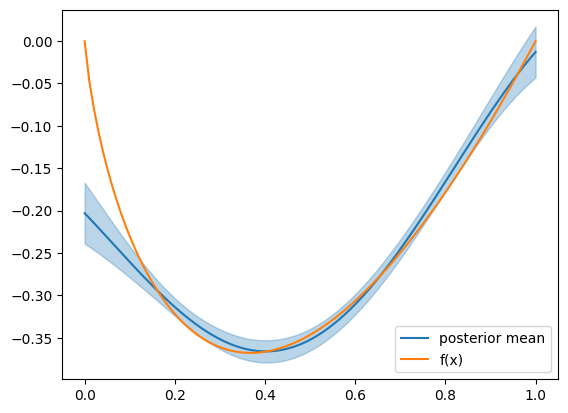

In [15]:
plt.plot(groundtruth_individuals, individuals_posterior_mean, label = 'posterior mean', color='C0')
plt.fill_between(groundtruth_individuals, lower_bound, upper_bound, alpha=0.3, color='C0')
# plt.plot(groundtruth_individuals, (conf[1]-conf[0]).detach().numpy(), label = '2 * posterior std')
plt.plot(groundtruth_individuals, func(groundtruth_individuals), label = 'f(x)', color='C1')
# plt.plot(xs, f(xs), '.', label = 'data points')
plt.legend()

In [16]:
groundtruth_individuals[np.argmin(func(groundtruth_individuals))]

tensor(0.3636)

In [17]:
groundtruth_individuals[np.argmin(individuals_posterior_mean)]

tensor(0.4040)

In [18]:
from BO import BayesOpt_UCB, BayesOpt_Random, PES

# a = 0.1
# b = 4
# c = 2
# d = 0
# sigma = 0.01

def g_oracle(y, a=0.1,b=4,c=2,d=0, sigma=0.01):
    g_value = g(y, a,b,c,d)
    z_value = g_value + np.random.normal(0, sigma)
    return z_value

x_space = torch.tensor(np.linspace(1e-5,1-1e-5,100)).float() # np.linspace(1e-5,1-1e-5,100)
y_space = torch.tensor(np.linspace(1e-5,1-1e-5,100)).float() # np.linspace(1e-5,1-1e-5,100)
init_y_size = 5
num_round = 20
num_repeat = 3
random_seeds = np.random.uniform(0,100, num_repeat)

pos_best_dict = {}

xs = torch.from_numpy(xs).float()
ys = torch.from_numpy(ys).float()

In [19]:
agent_pes = PES(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g_oracle,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp_mz.yaml', dump_dir='result/pes/',  y_min=-0.35, λ=0.01, num_opt_samples=10, random_seeds=random_seeds)
pos_best_dict['pes'] = agent_pes.simulation()

  0%|          | 0/3 [00:00<?, ?it/s]

[0.65626105 0.95489227 0.9708666  0.09784022 0.2407501 ]


Iteration 1: Elapsed Time: 5.248085975646973 seconds


Iteration 2: Elapsed Time: 5.17734694480896 seconds


Iteration 3: Elapsed Time: 5.054910898208618 seconds


Iteration 4: Elapsed Time: 5.298311710357666 seconds


Iteration 5: Elapsed Time: 5.382393836975098 seconds


Iteration 6: Elapsed Time: 5.4010701179504395 seconds


Iteration 7: Elapsed Time: 5.641067028045654 seconds


Iteration 8: Elapsed Time: 5.5876147747039795 seconds


Iteration 9: Elapsed Time: 5.944359064102173 seconds


Iteration 10: Elapsed Time: 5.813665866851807 seconds


Iteration 11: Elapsed Time: 5.727408170700073 seconds


Iteration 12: Elapsed Time: 5.992480039596558 seconds


Iteration 13: Elapsed Time: 6.193095922470093 seconds


Iteration 14: Elapsed Time: 5.998750925064087 seconds


100%|██████████| 15/15 [01:24<00:00,  5.64s/it]

Iteration 15: Elapsed Time: 6.1084558963775635 seconds



 33%|███▎      | 1/3 [01:24<02:49, 84.92s/it]

[0.50066811 0.46806806 0.5007825  0.14918518 0.82027152]


Iteration 1: Elapsed Time: 5.034497022628784 seconds


Iteration 2: Elapsed Time: 5.016891002655029 seconds


Iteration 3: Elapsed Time: 5.144352912902832 seconds


Iteration 4: Elapsed Time: 6.243980169296265 seconds


Iteration 5: Elapsed Time: 5.283459186553955 seconds


Iteration 6: Elapsed Time: 5.611207962036133 seconds


Iteration 7: Elapsed Time: 5.79003119468689 seconds


Iteration 8: Elapsed Time: 5.925638914108276 seconds


Iteration 9: Elapsed Time: 6.229547023773193 seconds


Iteration 10: Elapsed Time: 6.011500120162964 seconds


Iteration 11: Elapsed Time: 5.902657985687256 seconds


Iteration 12: Elapsed Time: 6.147289037704468 seconds


Iteration 13: Elapsed Time: 6.236983060836792 seconds


Iteration 14: Elapsed Time: 6.422919988632202 seconds


100%|██████████| 15/15 [01:27<00:00,  5.83s/it]

Iteration 15: Elapsed Time: 6.277998685836792 seconds



 67%|██████▋   | 2/3 [02:52<01:26, 86.57s/it]

[0.31083358 0.81898083 0.33475592 0.19371964 0.11032112]


Iteration 1: Elapsed Time: 5.008289575576782 seconds


Iteration 2: Elapsed Time: 5.282709121704102 seconds


Iteration 3: Elapsed Time: 5.480664014816284 seconds


Iteration 4: Elapsed Time: 5.400330066680908 seconds


Iteration 5: Elapsed Time: 5.308396100997925 seconds


Iteration 6: Elapsed Time: 5.677389144897461 seconds


Iteration 7: Elapsed Time: 5.701846122741699 seconds


Iteration 8: Elapsed Time: 5.894730091094971 seconds


Iteration 9: Elapsed Time: 5.8755388259887695 seconds


Iteration 10: Elapsed Time: 5.968864917755127 seconds


Iteration 11: Elapsed Time: 6.011630058288574 seconds


Iteration 12: Elapsed Time: 6.122010946273804 seconds


Iteration 13: Elapsed Time: 6.25000786781311 seconds


Iteration 14: Elapsed Time: 6.285468816757202 seconds


100%|██████████| 15/15 [01:26<00:00,  5.78s/it]

Iteration 15: Elapsed Time: 6.300770044326782 seconds



100%|██████████| 3/3 [04:19<00:00, 86.54s/it]


<Figure size 640x480 with 0 Axes>

In [20]:
agent_pes.z_rewards

tensor([-0.2386, -0.3228, -0.2506, -0.1799, -0.1418, -0.2310, -0.2304, -0.2450,
        -0.2237, -0.2397, -0.1071, -0.0926, -0.2307, -0.2369, -0.0957, -0.2556,
        -0.0968, -0.2547, -0.1227, -0.2621])

(array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

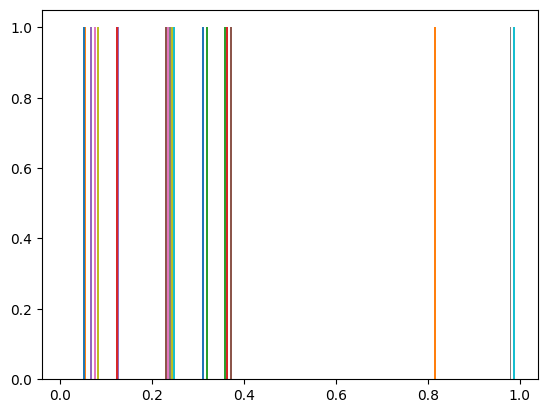

In [21]:
plt.hist(agent_pes.y_recs)

In [22]:
# agent_ucb = BayesOpt_UCB(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g_oracle,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp_mz.yaml', dump_dir='result/ucb/', random_seeds=random_seeds)
# pos_best_dict['ucb'] = agent_ucb.simulation()

In [23]:
agent_random = BayesOpt_Random(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g_oracle,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp_mz.yaml', dump_dir='result/random/', random_seeds=random_seeds)
pos_best_dict['random']= agent_random.simulation()

  0%|          | 0/3 [00:00<?, ?it/s]

[0.65626105 0.95489227 0.9708666  0.09784022 0.2407501 ]


Iteration 1: Elapsed Time: 2.787285089492798 seconds


Iteration 2: Elapsed Time: 2.8186912536621094 seconds


Iteration 3: Elapsed Time: 2.987044095993042 seconds


Iteration 4: Elapsed Time: 2.870806932449341 seconds


Iteration 5: Elapsed Time: 2.7814228534698486 seconds


Iteration 6: Elapsed Time: 2.744062900543213 seconds


Iteration 7: Elapsed Time: 2.764965772628784 seconds


Iteration 8: Elapsed Time: 2.709169864654541 seconds


Iteration 9: Elapsed Time: 2.8073222637176514 seconds


Iteration 10: Elapsed Time: 2.778557062149048 seconds


Iteration 11: Elapsed Time: 2.7110791206359863 seconds


Iteration 12: Elapsed Time: 2.7974610328674316 seconds


Iteration 13: Elapsed Time: 2.7642407417297363 seconds


Iteration 14: Elapsed Time: 2.775308847427368 seconds


100%|██████████| 15/15 [00:41<00:00,  2.80s/it]

Iteration 15: Elapsed Time: 2.8238260746002197 seconds



 33%|███▎      | 1/3 [00:42<01:24, 42.16s/it]

[0.50066811 0.46806806 0.5007825  0.14918518 0.82027152]


Iteration 1: Elapsed Time: 2.7390007972717285 seconds


Iteration 2: Elapsed Time: 2.7043352127075195 seconds


Iteration 3: Elapsed Time: 2.7179689407348633 seconds


Iteration 4: Elapsed Time: 2.675995111465454 seconds


Iteration 5: Elapsed Time: 2.7682690620422363 seconds


Iteration 6: Elapsed Time: 2.7432539463043213 seconds


Iteration 7: Elapsed Time: 2.743975877761841 seconds


Iteration 8: Elapsed Time: 2.7679197788238525 seconds


Iteration 9: Elapsed Time: 2.753680944442749 seconds


Iteration 10: Elapsed Time: 2.7522408962249756 seconds


Iteration 11: Elapsed Time: 2.765892267227173 seconds


Iteration 12: Elapsed Time: 2.9106569290161133 seconds


Iteration 13: Elapsed Time: 2.75703501701355 seconds


Iteration 14: Elapsed Time: 2.7820067405700684 seconds


 67%|██████▋   | 2/3 [01:23<00:41, 41.91s/it]

Iteration 15: Elapsed Time: 2.935783863067627 seconds
[0.31083358 0.81898083 0.33475592 0.19371964 0.11032112]


Iteration 1: Elapsed Time: 2.6931047439575195 seconds


Iteration 2: Elapsed Time: 2.807481288909912 seconds


Iteration 3: Elapsed Time: 2.849331855773926 seconds


Iteration 4: Elapsed Time: 2.786750078201294 seconds


Iteration 5: Elapsed Time: 2.71376633644104 seconds


Iteration 6: Elapsed Time: 2.7387609481811523 seconds


Iteration 7: Elapsed Time: 2.7911570072174072 seconds


Iteration 8: Elapsed Time: 2.75400972366333 seconds


Iteration 9: Elapsed Time: 2.7725939750671387 seconds


Iteration 10: Elapsed Time: 2.7587058544158936 seconds


Iteration 11: Elapsed Time: 2.7378602027893066 seconds


Iteration 12: Elapsed Time: 2.768955945968628 seconds


Iteration 13: Elapsed Time: 2.7607710361480713 seconds


Iteration 14: Elapsed Time: 2.730360746383667 seconds


100%|██████████| 15/15 [00:41<00:00,  2.77s/it]

Iteration 15: Elapsed Time: 2.8021140098571777 seconds



100%|██████████| 3/3 [02:05<00:00, 41.86s/it]


<Figure size 640x480 with 0 Axes>

(array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

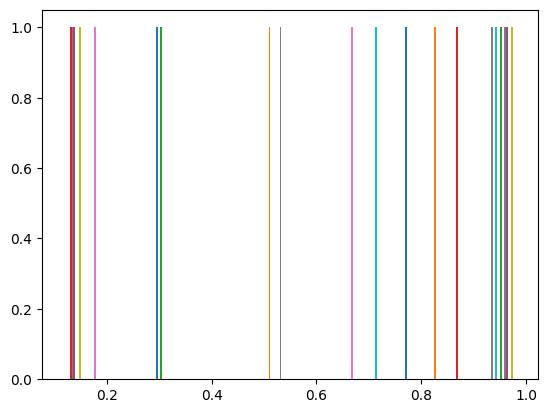

In [24]:
plt.hist(agent_random.y_recs)

In [25]:
def evalaution(pos_best_dict):
    # plt.plot(range(self.n), self.z_rewards[self.init_y_recs_size:], '.', label = 'z rewards')
    for name, pos_bests in pos_best_dict.items():
        opt = np.min(func(x_space.numpy()))
        regret_mean =np.abs(opt - pos_bests).mean(axis=0)
        regret_std =np.abs(opt - pos_bests).std(axis=0)
        # print(regret_mean)
        plt.plot(range(len(regret_mean)), regret_mean, label = name)
        plt.fill_between(range(len(regret_mean)), regret_mean - 2 * regret_std, regret_mean + 2 * regret_std, alpha = 0.3)
    plt.legend()
    plt.xlabel('Round')
    plt.ylabel('Regret')  

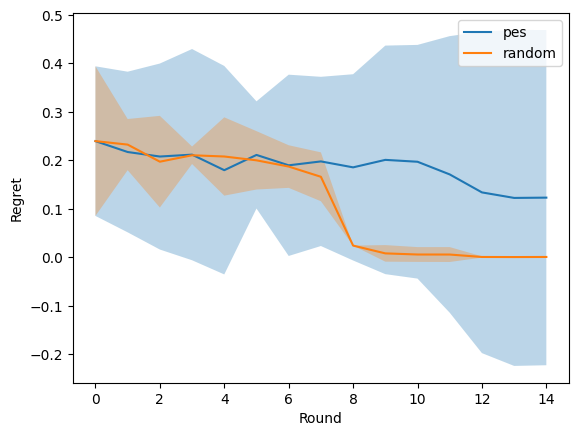

In [26]:
evalaution(pos_best_dict)

In [27]:
pos_best_dict['pes'][-1]


[tensor(-0.1060),
 tensor(-0.1060),
 tensor(-0.1060),
 tensor(-0.0789),
 tensor(-0.1508),
 tensor(-0.1873),
 tensor(-0.2558),
 tensor(-0.2316),
 tensor(-0.2441),
 tensor(-0.2441),
 tensor(-0.2558),
 tensor(-0.3342),
 tensor(-0.3670),
 tensor(-0.3676),
 tensor(-0.3675)]

In [28]:
# np.save('pos-seed24.npy', pos_best_dict)